Making some cyberpunk themed plots for CC Cet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from matplotlib import cm
import mplcyberpunk
from astropy.convolution import convolve, Box1DKernel
from scipy.optimize import leastsq
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting



%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/media/david/5tb_storage1/cc_cet/hst/data/'
x1ds = glob.glob(path+'*x1dsum.fits')

ism = Table.read('../../ism_lines.csv')
ism.dtype.names

mw, mf = np.loadtxt('models/ldlc01010.dk', unpack=True, skiprows=34)

[3.78247978e+30]


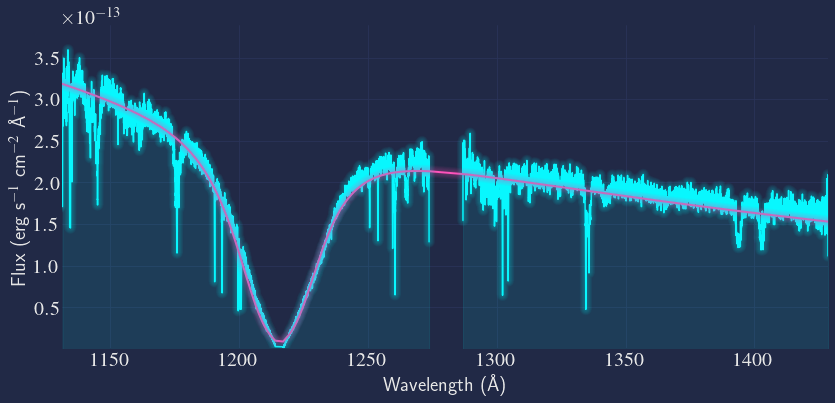

In [11]:
si2 = [1264.738]
si3 = [1294.545,1296.726,1298.892,1301.149,1303.323,1312.591]
si4 = [1393.775,1402.770]
c3 = [1174.935, 1175.265, 1175.592, 1175.713, 1175.713, 1175.989, 1176.372]

plt.style.use("cyberpunk")
plt.figure(figsize=(12, 6))
smooth = 5
x = x1ds[0]
data = fits.getdata(x,1)
wb = np.array([], dtype=float)
fb = np.array([], dtype=float)
eb = np.array([], dtype=float)
for dt in data[::-1]:
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (f>0) & (dq == 0) & (w < 1214) | (w > 1217) & (f>0) & (dq == 0) 
    w, f, e = w[mask], f[mask], e[mask]
    wb = np.concatenate((wb, w))
    fb = np.concatenate((fb, f))
    eb = np.concatenate((eb, e))    
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    plt.plot(w, f, c='C0')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
#[plt.axvline(line, ls='--', c='C2', alpha=0.5) for line in ism['rest_lambda']]
plt.xlim(wb[0], wb[-1])
plt.ylim(0.1e-14, 3.89e-13)

names = ['Si\,{\sc ii}', 'Si\,{\sc iii}', 'Si\,{\sc iv}', 'C\,{\sc iii}']
lines = [si2, si3, si4, [np.mean(c3)]]
#for name, si in zip(names, lines):
 #   [plt.annotate('',(line, 2.7e-13), xytext=(line, 3.2e-13),arrowprops=dict(arrowstyle='-'), horizontalalignment='center') for line in si]
  #  plt.annotate(name,(np.mean(si), 3.e-13), xytext=(np.mean(si), 3.3e-13), horizontalalignment='center', bbox=dict(facecolor='white', edgecolor='none'))

    

def residuals(scale, f, mf):
    return f - mf/scale
    
mmask = (mw > wb[0]) & (mw < wb[-1])
mw1, mf1 = mw[mmask], mf[mmask]

mf1 = interp1d(mw1, mf1, fill_value='extrapolate')(wb)
normfac = leastsq(residuals, 1., args=(fb, mf1))[0]

print(normfac)
    
#plt.plot(wb, mf1/normfac, c='C1', lw=2)
mplcyberpunk.add_underglow()
# mplcyberpunk.add_glow_effects()
plt.plot(wb, mf1/normfac, c='C1', lw=2)
mplcyberpunk.make_lines_glow()

plt.tight_layout()
#plt.savefig('plots/cc_cet_cos.pdf', dpi=300)
#plt.savefig('plots/cc_cet_cos.png',dip=150, facecolor='white')